In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from keras import backend as K
from keras.models import Model

from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout, GRU
from keras.optimizers import Adam

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
valid = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/handwrittenText_test/test.tsv', sep = '\ t',engine='python')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/handwrittenText_test/train.tsv', sep = '\ t',engine='python')

In [ ]:
import zipfile
test_zip = '/content/drive/MyDrive/Colab Notebooks/handwrittenText_test/test.zip' #путь к арихву с тестовыми данными
train_zip = '/content/drive/MyDrive/Colab Notebooks/handwrittenText_test/train.zip' #путь к архиву с обучающими данными
te = zipfile.ZipFile(test_zip, 'r')
te.extractall('.')
tr = zipfile.ZipFile(train_zip, 'r')
tr.extractall('.')
print(os.listdir())

['.config', 'drive', 'train', 'test', 'sample_data']


In [ ]:
def struc_data(image_path, labels_path, ignore=[]):

    symbols = []
    img_and_label = dict()

    see = open(labels_path, 'r', encoding='utf-8').read()
    temp = see.split('\n')
    for t in temp:
        try:
            x = t.split('\t')
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True
            if flag == False:
                img_and_label[image_path + x[0]] = x[1]
                for sym in x[1]:
                    if sym not in symbols:
                        symbols.append(sym)
        except:
            print('Ошибка значения:', x)
            pass

    img_path = list(img_and_label.keys())
    all_labels = list(img_and_label.values())

    symbols.sort()

    return img_path, all_labels, symbols

In [ ]:
# зададим пути для меток и самих изображений
PATH_LABELS_TEST = '/content/drive/MyDrive/Colab Notebooks/handwrittenText_test/test.tsv'
PATH_IMG_TEST = '/content/test/'
PATH_LABELS_TRAIN = '/content/drive/MyDrive/Colab Notebooks/handwrittenText_test/train.tsv'
PATH_IMG_TRAIN = '/content/train/'

img_path_test, labels_test, all_labels_test = struc_data(PATH_IMG_TEST, PATH_LABELS_TEST) 
img_path_all,  labels_all, all_labels_all = struc_data(PATH_IMG_TRAIN, PATH_LABELS_TRAIN) 

In [ ]:
#получаем обучающую выборку
from sklearn.model_selection import train_test_split
img_path_train, img_path_other, labels_train, labels_other = train_test_split(img_path_all,labels_all,
 train_size = 30000,
 random_state = 1)

In [ ]:
#получаем валидационную выборку
img_path_valid, img_path_del, labels_valid, labels_del = train_test_split(img_path_other, labels_other,
 train_size = 6000,
 random_state = 2)

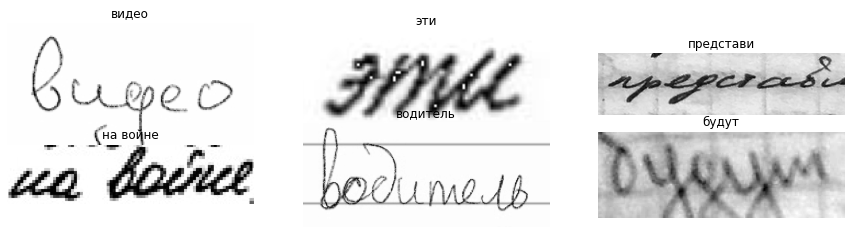

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = img_path_train[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(labels_train[i], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size = 30000 
train_x = []

for i in range(train_size):
    img_dir = img_path_train[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    # print(img_path_train[i])
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_size = len(labels_valid)
valid_x = []

for i in range(valid_size):
    img_dir = img_path_valid[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

In [ ]:
alphabets=u'{}'.format(''.join(all_labels_all))
max_str_len = 40 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'Овечка'
print(name, '\n',label_to_num(name))

Овечка 
 [43 60 63 81 68 58]


In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(labels_train[i])
    train_y[i, 0:len(labels_train[i])]= label_to_num(labels_train[i])    

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(labels_valid[i])
    valid_y[i, 0:len(labels_valid[i])]= label_to_num(labels_valid[i])    

In [ ]:
print('True label : ',labels_train[100] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  мужество, уверен- 
train_y :  [70. 77. 64. 63. 75. 76. 60. 72.  7.  0. 77. 60. 63. 74. 63. 71.  8. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1.] 
train_label_len :  [17.] 
train_input_len :  [62.]


In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.5)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(GRU(256, return_sequences=True), name = 'GRU1')(inner)
inner = Bidirectional(GRU(256, return_sequences=True), name = 'GRU2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [ ]:
# функция потерь CTC
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

h = model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
235/235 [==============================] - 70s 222ms/step - loss: 32.6899 - val_loss: 37.8684
Epoch 2/60
235/235 [==============================] - 48s 205ms/step - loss: 26.4998 - val_loss: 31.1819
Epoch 3/60
235/235 [==============================] - 49s 207ms/step - loss: 26.1420 - val_loss: 29.9603
Epoch 4/60
235/235 [==============================] - 50s 212ms/step - loss: 25.9219 - val_loss: 31.5751
Epoch 5/60
235/235 [==============================] - 48s 206ms/step - loss: 25.7504 - val_loss: 29.5731
Epoch 6/60
235/235 [==============================] - 48s 206ms/step - loss: 25.6120 - val_loss: 29.1274
Epoch 7/60
235/235 [==============================] - 48s 204ms/step - loss: 25.4864 - val_loss: 27.8554
Epoch 8/60
235/235 [==============================] - 49s 209ms/step - loss: 25.3264 - val_loss: 27.2103
Epoch 9/60
235/235 [==============================] - 50s 212ms/step - loss: 25.0956 - val_loss: 28.6772
Epoch 10/60
235/235 [==============================] - 

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

188/188 [==============================] - 5s 18ms/step


In [ ]:
y_true =labels_valid
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 

print('Предсказанные правильно символы: %.2f%%' %(correct_char*100/total_char))
print('Предсказанные правильно слова: %.2f%%' %(correct*100/valid_size))

Предсказанные правильно символы: 45.13%
Предсказанные правильно слова: 23.20%


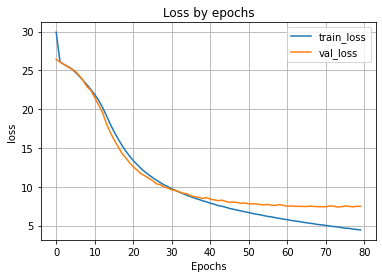

In [ ]:
plt.plot(h.history['loss']) 
plt.plot(h.history['val_loss']) 
plt.grid() 
plt.xlabel('Epochs') 
plt.ylabel('loss') 
plt.legend(['train_loss', 'val_loss']) 
plt.title('Loss by epochs') 
plt.show()

In [ ]:
from sklearn.metrics import hamming_loss
hamming_loss(y_true, prediction)

0.768

Все же попробуем сделать предсказания

1/1 [==============================] - 0s 25ms/step


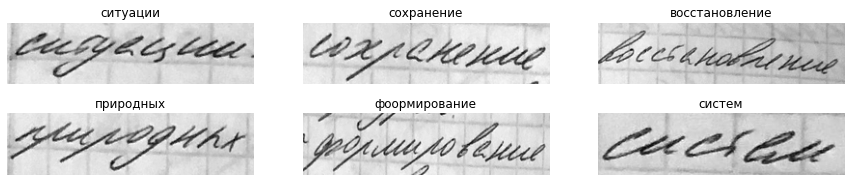

In [ ]:
test = img_path_all[32111:32120]
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = test[i]
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)